<a href="https://colab.research.google.com/github/beertocode/captchasolver/blob/master/captchasolver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %tensorflow_version 

In [ ]:

import keras
import pandas as pd
import tensorflow as tf
import numpy as np
import cv2
import random
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [ ]:
def flip_and_rot(img):  #images in dataset are rotated and flipped, this makes them alright
  img=img.astype('float32')
  img=cv2.flip(img,0) #flip along x axis
  img=cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
  return img

In [ ]:

dropped_labels=[0,2,12,13,16,17,18,19,21,24,28,29,30,34,36,37,40,41,43,44,45] #the labels which led to most misclassifications
train_data=pd.read_csv("/content/drive/My Drive/emnist-balanced-train.csv",names=list(range(785)),header=None)  #training
train_data=train_data[~train_data[0].isin(dropped_labels)]  #removing dropped_labels

train_labels1=train_data[[0]]    
train_labels1=train_labels1.to_numpy()
train_labels=np.array([])
for i in range(len(train_labels1)):
  train_labels=np.append(train_labels,train_labels1[i])
train_labels=train_labels.astype('int32')

train_data=train_data.to_numpy()[:,1:]
train_data=train_data.reshape((train_data.shape[0], 28,28))
for i in range(train_data.shape[0]):
  train_data[i]=flip_and_rot(train_data[i])



test_data=pd.read_csv("/content/drive/My Drive/emnist-balanced-test.csv",names=list(range(785)),header=None) #testing
test_data=test_data[~test_data[0].isin(dropped_labels)]

test_labels1=test_data[[0]]
test_labels1=test_labels1.to_numpy()
test_labels=np.array([])
for i in range(len(test_labels1)):
  test_labels=np.append(test_labels,test_labels1[i])
test_labels=test_labels.astype('int32')

test_data=test_data.to_numpy()[:,1:]
test_data=test_data.reshape((test_data.shape[0], 28,28))
for i in range(test_data.shape[0]):
  test_data[i]=flip_and_rot(test_data[i])
train_data.shape

(62400, 28, 28)

In [ ]:
no_of_labels=47-len(dropped_labels)
no_of_labels

26

In [ ]:
mappings={}
values=list(range(47))
characters=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','d','e','f','g','h','n','q','r','t']

for v in values:
  mappings[v]=characters[v]
  

X


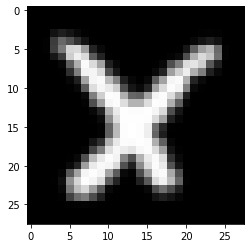

In [ ]:
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

i=random.randint(0,len(test_data))
img=test_data[i]
img=img.astype('float32')
# img=cv2.resize(img,(280,280))
plt.imshow(img, cmap=plt.cm.gray)   


cv2_imshow(img)
print(mappings[test_labels[i]])

In [ ]:
train_data, test_data = np.array(train_data, np.float32), np.array(test_data, np.float32)
train_data, test_data = train_data / 255-0.5, test_data / 255-0.5  #normalization of data


train_labels=tf.keras.utils.to_categorical(train_labels,47)

test_labels=tf.keras.utils.to_categorical(test_labels,47)
train_data=np.expand_dims(train_data,axis=-1)
test_data=np.expand_dims(test_data,axis=-1)

In [ ]:
train_data.shape

(62400, 28, 28, 1)

In [ ]:
def squeeze_excite_block2D(filters,input):                       # squeeze and exite is a good thing
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Reshape((1, filters))(se) 
    se = tf.keras.layers.Dense(filters//32, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    se = tf.keras.layers.multiply([input, se])
    return se
    

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, shear_range=10,
                                                          height_shift_range=0.1, zoom_range=0.2,horizontal_flip=True,vertical_flip=True)
datagen.fit(train_data)
datagen2 = tf.keras.preprocessing.image.ImageDataGenerator()
datagen2.fit(test_data)

In [ ]:
train_data.shape

(62400, 28, 28, 1)

In [ ]:
def make_model():
        s = tf.keras.Input(shape=train_data.shape[1:]) 
        x = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(s)
        x = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
        x = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = squeeze_excite_block2D(128,x)

        x = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
        x = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
        x = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = squeeze_excite_block2D(128,x)
        x = tf.keras.layers.AveragePooling2D(2)(x)


        x = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
        x = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
        x = tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = squeeze_excite_block2D(128,x)
        x = tf.keras.layers.AveragePooling2D(2)(x)


        x = tf.keras.layers.concatenate([tf.keras.layers.GlobalMaxPooling2D()(x),
                                         tf.keras.layers.GlobalAveragePooling2D()(x)])

        x = tf.keras.layers.Dense(47,activation='softmax',use_bias=False,
                                  kernel_regularizer=tf.keras.regularizers.l1(0.00025))(x) # this make stacking better
        return tf.keras.Model(inputs=s, outputs=x)

In [ ]:
model=make_model()
for layer in model.layers:
  layer.trainable=True
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 128)  1280        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 128)  147584      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 128)  147584      conv2d_1[0][0]                   
_____________

In [ ]:
batch_size=32
supermodel=[]
for i in range(1):
        np.random.seed(i)
        model=make_model()                
        model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
        model.fit_generator(datagen.flow(train_data, train_labels, batch_size=batch_size,shuffle=True),
                    steps_per_epoch=len(train_data) / batch_size, epochs=13,verbose=0)
        model.compile(optimizer=optimizers.Adam(lr=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])
        model.fit_generator(datagen.flow(train_data, train_labels, batch_size=batch_size,shuffle=True),
                    steps_per_epoch=len(train_data) / batch_size, epochs=3,verbose=0)
        model.compile(optimizer=optimizers.Adam(lr=0.00001), loss='categorical_crossentropy',metrics=['accuracy'])
        model.fit_generator(datagen.flow(train_data, train_labels, batch_size=batch_size,shuffle=True),
                    steps_per_epoch=len(train_data) / batch_size, epochs=3,verbose=0)
        model.fit(train_data, train_labels, batch_size=batch_size,shuffle=True, epochs=1,verbose=0)
        supermodel.append(model)
        print(i,'acc:',accuracy_score(np.argmax(test_labels,axis=1),np.argmax(model.predict(test_data),axis=1)))
        model.save('/content/drive/My Drive/Mosaic/model1.{}.h5'.format(i))

0 acc: 0.9921153846153846
1 acc: 0.99125
2 acc: 0.9927884615384616
3 acc: 0.9920192307692308
4 acc: 0.9933653846153846
5 acc: 0.9925961538461539
6 acc: 0.9919230769230769
7 acc: 0.9921153846153846
8 acc: 0.9918269230769231
9 acc: 0.9920192307692308


In [ ]:
P=np.asarray([a.predict(test_data) for a in supermodel])

In [ ]:
accuracy_score(np.argmax(test_labels,axis=1),np.argmax(np.mean(P,axis=0),axis=1)) # 20 models stack accurasy 

0.9935576923076923

In [ ]:
print(test_labels[0])
P[0][0]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


array([1.54474364e-07, 1.46010080e-07, 1.54461560e-07, 6.88710555e-09,
       3.55134344e-09, 9.72376100e-08, 1.56868409e-05, 1.29561389e-10,
       1.88100216e-06, 6.98741474e-07, 1.11600485e-07, 1.11333190e-06,
       1.54474961e-07, 1.54475543e-07, 1.13040835e-04, 7.09511596e-07,
       1.54431646e-07, 1.54467003e-07, 1.54473341e-07, 1.54453460e-07,
       1.69645329e-08, 1.54435781e-07, 5.36733680e-09, 2.41043011e-07,
       1.54454781e-07, 2.58226805e-07, 6.18138529e-07, 4.89657541e-05,
       1.54463464e-07, 1.54451399e-07, 1.54466576e-07, 5.18930278e-07,
       1.31617384e-08, 7.91894017e-09, 1.54467003e-07, 2.60083539e-06,
       1.54478201e-07, 1.54466719e-07, 2.45937645e-05, 9.99681950e-01,
       1.54464502e-07, 1.54466122e-07, 2.57425601e-08, 1.54457581e-07,
       1.54443740e-07, 1.54446525e-07, 1.03578386e-04], dtype=float32)

In [ ]:
from tensorflow.keras.models import load_model

model=load_model("/content/drive/My Drive/5th model(26 chars).h5")

In [ ]:
#2nd model

In [ ]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [ ]:
from keras.layers import Conv2D,BatchNormalization,Dense,Dropout,Flatten
from keras.models import Sequential
from keras.optimizers import Adam
nets = 10
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(47, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model[0].summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_36 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_37 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_38 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_16 (Dropout)         (None, 12, 12, 32)       

In [ ]:

# DECREASE LEARNING RATE EACH EPOCH
annealer = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
history = [0] * nets
epochs = 45
for j in range(nets):
    if j==0:
      continue
    # X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(train_data,train_labels, batch_size=64),
        epochs = epochs, steps_per_epoch = train_data.shape[0]//64, callbacks=[annealer], verbose=0)
    
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}".format(
        j+1,epochs,max(history[j].history['acc'])))
    model[j].save('/content/drive/My Drive/Mosaic/model2.{}.h5'.format(j+5))

CNN 2: Epochs=45, Train accuracy=0.98915
CNN 3: Epochs=45, Train accuracy=0.98909
CNN 4: Epochs=45, Train accuracy=0.98934
CNN 5: Epochs=45, Train accuracy=0.98941


KeyboardInterrupt: ignored

In [ ]:
print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}".format(
        1,epochs,max(history[0].history['acc'])))
model[0].save('/content/drive/My Drive/Mosaic/model2.{}'.format(0)) 

In [ ]:
P=np.asarray([a.predict(test_data) for a in model])

In [ ]:
accuracy_score(np.argmax(test_labels,axis=1),np.argmax(np.mean(P,axis=0),axis=1)) # 20 models stack accurasy 

In [ ]:
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("Confusion matrix.jpg")

In [ ]:

from tensorflow.keras.models import load_model
model=load_model("/content/drive/My Drive/Mosaic/model1.4")
P=np.asarray([model.predict(test_data)])
final_pred=np.argmax(np.mean(P,axis=0),axis=1)
acc=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(np.mean(P,axis=0),axis=1))
print(acc)

%matplotlib inline
from sklearn.metrics import confusion_matrix


cm=confusion_matrix(np.argmax(test_labels,axis=1), final_pred)
cm_plot_labels=list(range(47))
plot_confusion_matrix(cm, cm_plot_labels)
# np.savetxt("confMat.csv", cm.astype(int), delimiter=",")


KeyboardInterrupt: ignored

{1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 20, 22, 23, 25, 26, 27, 31, 32, 33, 35, 38, 39, 42, 46}
Confusion matrix, without normalization
[[397   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   2   0   0   0   0]
 [  0 397   0   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1   0   0   0   0]
 [  0   0 398   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0 400   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   1 399   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 400   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   1   0   1   0   0 396   0   0   0   0   1   0   0   0   1   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 399   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0 

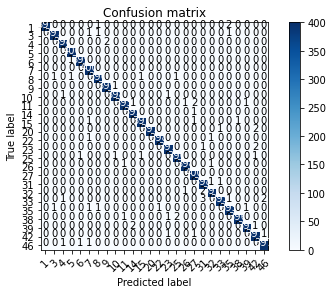

In [ ]:
mappings={}
values=list(range(47))
characters=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','d','e','f','g','h','n','q','r','t']# all initial characters

for v in values:
  mappings[v]=characters[v]

dropped_labels=set([0,2,12,13,16,17,18,19,21,24,28,29,30,34,36,37,40,41,43,44,45])#the labels which led to most misclassifications, after examining confusion matrix
all=set(values)
usinglabels=all-dropped_labels #set of values used
print(usinglabels)

import itertools
plot_confusion_matrix(cm,usinglabels)

In [ ]:
P=np.asarray([model.predict(test_data)])
final_pred=np.argmax(np.mean(P,axis=0),axis=1)
acc=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(np.mean(P,axis=0),axis=1))
print(acc)

KeyboardInterrupt: ignored

In [ ]:
import csv
import pandas as pd

data = csv.reader(open('results_date.csv', 'r'), delimiter=";", quotechar='|')
next(data)

true_data = []
pred_data = []

for row in data:
    if len(row) >= 2:
        true_data.append(row[0])
        pred_data.append(row[1])

true_data = [s.strip().split('_')[0] for s in true_data]
pred_data = [s.strip().split('=')[0] for s in pred_data]

y_true = pd.Series(true_data, name="Actual")
y_pred = pd.Series(pred_data, name="Predicted")
df_confusion = pd.crosstab(y_true, y_pred)
print (df_confusion)